In [1]:
import pandas as pd
import numpy as np
import warnings

dataset = pd.read_csv('IMDB Dataset.csv')
dataset
# warnings.filterwarnings('ignore')

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [2]:
dataset.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

C:\Users\ka_ya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

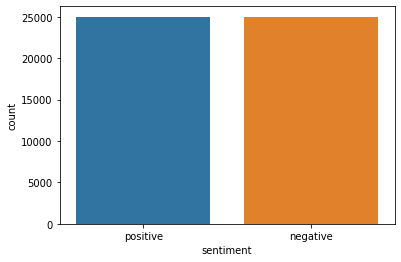

In [3]:
import seaborn as sns
sns.countplot(dataset.sentiment)

In [4]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

dataset['review'] = dataset['review'].apply(cleanText)
dataset

C:\Users\ka_ya\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [5]:
corpus = []
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
for text in dataset['review']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
    
num_words = len(corpus)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ka_ya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['review'].values,dataset['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Found unique tokens: {}'.format(len(word_index)))

Found unique tokens: 113698


In [8]:
embedded_words = {}
with open('glove.6B.200d.txt', encoding="utf8") as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,200,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          22739800  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [11]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 30 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/30
1250/1250 [==============================] - 177s 137ms/step - loss: 0.5168 - accuracy: 0.7446 - val_loss: 0.4022 - val_accuracy: 0.8213
Epoch 2/30
1250/1250 [==============================] - 171s 137ms/step - loss: 0.3708 - accuracy: 0.8387 - val_loss: 0.3389 - val_accuracy: 0.8562
Epoch 3/30
1250/1250 [==============================] - 169s 135ms/step - loss: 0.3322 - accuracy: 0.8605 - val_loss: 0.3381 - val_accuracy: 0.8568
Epoch 4/30
1250/1250 [==============================] - 180s 144ms/step - loss: 0.3046 - accuracy: 0.8730 - val_loss: 0.3243 - val_accuracy: 0.8611
Epoch 5/30
1250/1250 [==============================] - 217s 174ms/step - loss: 0.2841 - accuracy: 0.8828 - val_loss: 0.3214 - val_accuracy: 0.8569
Epoch 6/30
1250/1250 [==============================] - 161s 129ms/step - loss: 0.2617 - accuracy: 0.8935 - val_loss: 0.2965 - val_accuracy: 0.8773
Epoch 7/30
1250/1250 [==============================] - 152s 121ms/step - loss: 0.2411 - accuracy: 0.9014 - val_

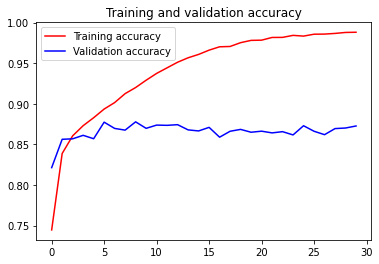

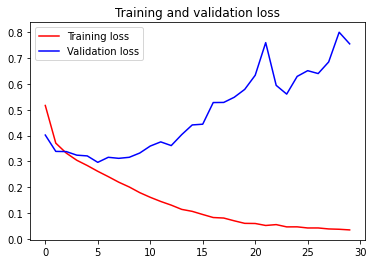

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [13]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9880499839782715
Validation Accuracy: 0.8776999711990356


In [14]:
def get_result(txt):
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=200, dtype='int32', value=0)
    pred = model.predict(padded)
    print(pred)
    labels = [0,1]
    result = labels[round(pred[0][0])]
    result_dict = {0: 'negative', 1: 'positive'}
    print(result)
    return result_dict[result]


In [15]:
m = "This movie was not good at all. It had some good parts like the acting was pretty good but the story was not impressing at all."
get_result([m])

1/1 [==============================] - 1s 1s/step
[[0.0053707]]
0


'negative'

In [16]:
m = "I can watch this movie forever just because of the beauty in its cinematography."
get_result([m])

1/1 [==============================] - 0s 36ms/step
[[0.9956735]]
1


'positive'

In [17]:
import tweepy as tw
# from tweepy import OAuthHandler
bearer_token = "AAAAAAAAAAAAAAAAAAAAALaldgEAAAAAcqfFwbU6d3dcjZdix0LXufZUBBs%3DrQ8aT9ewhYZ1ETk6OJYXOkgn0CIIa3SL6mHwo8BIO3O3MmbSkE"

In [18]:
try:
#     auth = tw.OAuth1UserHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_token, access_token_secret)
#     api = tw.API(auth)
    
#     auth = tw.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
#     api = tw.API(auth)
    
    auth = tw.OAuth2BearerHandler(bearer_token)
    api = tw.API(auth)
    
except:
    print("Error: Authentication Failed")

In [19]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [20]:
def isEnglish(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [21]:
from datetime import datetime, timedelta

now = datetime.today().now()
prev=now-timedelta(days=1)
now=now.strftime("%Y-%m-%d")
prev=prev.strftime("%Y-%m-%d")
prev

'2022-06-18'

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    #text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text_tokens = word_tokenize(text)
    filtered_words = [w for w in text_tokens if not w in stop_words]
    
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    
    
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ka_ya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def get_tweets(query, count):
    tweets = []
    query = query + " -filter:retweets"
    
    try:
        fetched_tweets = tw.Cursor(api.search_tweets, 
                                   q = query, 
                                   lang = 'en',
                                  since = prev,
                                  until = now).items(count)
        #api.search(q = query, count = count, lang = 'en')
        
        for tweet in fetched_tweets:
            parsed_tweet = {}
            print(tweet.text)
            if isEnglish(tweet.text) == True:
                parsed_tweet['text'] = preprocess_text(tweet.text)
                parsed_tweet['sentiment'] = get_result([preprocess_text(tweet.text)])
            
                if tweet.retweet_count > 0:
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                    
                else:
                    tweets.append(parsed_tweet)
                
        return tweets
    
    except AttributeError as e:
        print("Error : " + str(e))
        

In [45]:
key = "#" + input ("Enter key or hashtag to search about: ")
numberOfTweets = int(input("Enter how many tweets to analyze: "))

Enter key or hashtag to search about:  Lightyear
Enter how many tweets to analyze:  100


In [46]:
tweets = get_tweets(key, numberOfTweets)
pzt_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
neg_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']

Unexpected parameter: since


Do I see #Lightyear in theaters or wait for it to hit Dizz Dizz Plus?
1/1 [==============================] - 0s 31ms/step
[[0.94481516]]
1
Today I'm going to see #Lightyear https://t.co/qCCk8U6OVn
1/1 [==============================] - 0s 25ms/step
[[0.99867254]]
1
Lightyear is a better version of interstellar #Lightyear
1/1 [==============================] - 0s 26ms/step
[[0.76340145]]
1
#Lightyear was so good ahhhhh my heart 💚💜
My week is free. Anyone want to see the new #Lightyear movie with me.
1/1 [==============================] - 0s 28ms/step
[[0.9788121]]
1
"I'm supposed to be like my grandma"

'No, you're Izzy!' shouts a little girl from the audience. #Lightyear
1/1 [==============================] - 0s 30ms/step
[[0.9178582]]
1
#Lightyear To infinity…..and…. BEYOND https://t.co/hCIKG8Ncwt
How does Andy watch #Lightyear  and not buy Sox? https://t.co/nrbdbFKItU
1/1 [==============================] - 0s 25ms/step
[[0.8917448]]
1
I think Luke would agree his first movie theater 

Unexpected parameter: since


[[0.49700868]]
0
Seated for a second round of #Lightyear and look what I spotted. Trailer coming very soon I believe. #BlackPanther… https://t.co/fAWhBatZWr
Seated for #Lightyear very excited https://t.co/h89BuNNqoS
1/1 [==============================] - 0s 31ms/step
[[0.6215]]
1
We took a couple of 7-year-olds to see #Lightyear. The movie isn't great but the kids certainly enjoyed it. The kis… https://t.co/sBf2S8JMmY
If #ucanonlypick1 favourite actor/actress from Disney &amp; Pixar's #Lightyear 

Chris Evans, Keke Palmer, James Brolin… https://t.co/HvXSSVbrCs
Bro little kids should not be taken to movie theaters, unless they know how to stop talking! Smh lmao. That’s why m… https://t.co/poxSaPf21z
#Lightyear tomorrow night and I can’t even express how excited I am!
The only cat I ever want is Sox #Lightyear
1/1 [==============================] - 0s 24ms/step
[[0.98461986]]
1
I just saw #Lightyear for the first time. 9/10! Lived up to my incredibly high expectations. Don't go in with t

Unexpected parameter: since


[[1.3447263e-05]]
0
#Lightyear spoiler no context: https://t.co/c5kMmTmA5p
1/1 [==============================] - 0s 16ms/step
[[0.8971754]]
1
Wow. Lightyear was ever better than I’d anticipated! Chris Evans nailed it, the animation was incredible, the story… https://t.co/iLL8X6Pz69
i will not be rolling out for #Lightyear im sorry to say shoutout to the buzzheads tho
1/1 [==============================] - 0s 27ms/step
[[0.00240013]]
0
Yes I am an adult who spent his money on a Buzz #Lightyear action figure after seeing the movie. https://t.co/EIYdxAIlIn
1/1 [==============================] - 0s 25ms/step
[[0.00067853]]
0
Being sick on Father's Day weekend suck ass.

Can't spend time with Regan like I want to. Couldn't go see… https://t.co/kvuFgcuIoL
@hudabeauty eyeshadow for this buzz lightyear inspired look! 😍 #Lightyear https://t.co/cNS6E3rcau
@ChrisEvans with puppies is on the Mister Rogers level of good and pure we all need.  And that may be a pun but it… https://t.co/yaBNSsGvyq
W

Unexpected parameter: since


[[0.9804198]]
1
Yet in these people’s warped minds stuff like a man kissing a naked 16 year old non-verbal girl on a beach (The Lit… https://t.co/AdVH8EpQZu
What's your favorite Pixar movie of all time?

#FilmTwitter #ToyStory #Lightyear #Pixar https://t.co/ZE0fDAgBJP
1/1 [==============================] - 0s 31ms/step
[[0.8826857]]
1
Saw #Lightyear 
Made a drawing. https://t.co/cCsqaatOJC
1/1 [==============================] - 0s 18ms/step
[[0.82613873]]
1
Get Woke Go Broke!!

@PixarsLightyear @Disney @disneyplus @MarvelStudios
 
#MsMarvel #Lightyear #MCU #Pixar… https://t.co/PnkLHPfAhf
It’s been 22 years and I can EASILY state that this is still the best Buzz #Lightyear movie out there. https://t.co/5JlnQpVuzQ
#Lightyear is fun though will be forgettable, but the moment at the start when Deb said he sounds like George Cloon… https://t.co/FsAWPN4BHM
I got my Vic Viper...I mean, the XL-07. 😉 #Lightyear https://t.co/dsywg3KqET
Enjoyed #lightyear not the most memorable Pixar film but a g

Unexpected parameter: since


[[0.9987642]]
1
#Lightyear Open: $55M-ish
Average 3-Day Open of a #ToyStory film: $79.4M

#PussInBoots Open: $34.1M
Average Open of… https://t.co/YrbOwDHd57
Took my Buzz Lightyear to #Lightyear. Bravo @AngusMacLane and @Pixar for an epic sci-fi adventure. Loved the nods t… https://t.co/m4Zdg9d09c
I don't understand why people are making such a huge deal about the less than 5 seconds of #LGBTQ representation in… https://t.co/Ru4inbFVPg
#Lightyear was extremely ...meh. It's like they had to produce a movie and this vanilla thing was the thing they ca… https://t.co/jOQd4nku1S
#Lightyear is a sad, strange little movie, and it has my pity
1/1 [==============================] - 0s 31ms/step
[[0.0017974]]
0
#Lightyear has been reimagined as a PS1 game in a brand new video from @Hoolopee.

https://t.co/8oVc8wpVkX https://t.co/zVbT3Dp0Fk
1/1 [==============================] - 0s 30ms/step
[[0.79100156]]
1
Snuck into this party because they have good mirrors

#Lightyear https://t.co/TVmCeQoMRp
1

Unexpected parameter: since


[[0.9996364]]
1
Happy Pride #BuzzLightyear #Lightyear https://t.co/574Mt4rI5Y
1/1 [==============================] - 0s 30ms/step
[[0.96136236]]
1
Need to be watching #Lightyear
1/1 [==============================] - 0s 30ms/step
[[0.17968866]]
0
Worth the good 11 years before! #ToyStory #Lightyear https://t.co/kJ3AAmchfA
1/1 [==============================] - 0s 30ms/step
[[0.9923666]]
1
Just got #home from seeing the new #Lightyear movie with the #family and we all loved it! The movie had a very good… https://t.co/HQPJ3rSW7z
Taika Waititi, Keke Palmer and Chis Evans light up the blue carpet at the #Lightyear premiere https://t.co/T0qmeFENLN
1/1 [==============================] - 0s 29ms/step
[[0.9969051]]
1
Would you guys like see me do #Lightyear #Roleplay with gear toys videos? 
Inspired #LGBTQAlly #Pride represent in… https://t.co/WYIoLlAnbv
The Pizza Planet truck made an appearance in #Lightyear https://t.co/8vh4cV4z04
1/1 [==============================] - 0s 28ms/step
[[0.38022

Unexpected parameter: since


[[0.99577266]]
1
.@RegalMovies 7pm and there’s 40 people in all 4 lines at the snack counters and no one at the ticket booth or cust… https://t.co/ruemT6gqQU
If #Lightyear is a live action movie in the Toy story universe does that mean Chris Evans plays buzz Lightyear in t… https://t.co/CzR1gbCLqP
THANK YOU @Pixar for this amazing movie!!!!! My kids loved #Lightyear  SO much, my 3 year old son is the biggest bu… https://t.co/4Z7P98futc
TW / / ment  of  pr0sh1pper,  pr0sh1pper  &amp; ment  of  the  word  r@p3  in  the  picture 

Please... #Lightyear  is… https://t.co/Wl4rBpbTnh
In the #ToyStory universe, #Lightyear was a movie released in 1995. It would definitely have a reboot or legacy seq… https://t.co/eYYRod3sSh
https://t.co/cJWV8DVvqD My review of #Lightyear starring @PEETSOWN and @ChrisEvans
1/1 [==============================] - 0s 29ms/step
[[0.9983434]]
1
Just left the theatre from watching #Lightyear I’ve never felt such nostalgia, not only from growing up watching th… https:/

In [47]:
pzt_tweets

[{'text': 'Do I see Lightyear theaters wait hit Dizz Dizz Plus ?',
  'sentiment': 'positive'},
 {'text': "Today I 'm going see Lightyear", 'sentiment': 'positive'},
 {'text': 'Lightyear better version interstellar Lightyear',
  'sentiment': 'positive'},
 {'text': 'My week free . Anyone want see new Lightyear movie .',
  'sentiment': 'positive'},
 {'text': "`` I 'm supposed like grandma '' 'No , 're Izzy ! ' shouts little girl audience . Lightyear",
  'sentiment': 'positive'},
 {'text': 'How Andy watch Lightyear buy Sox ?', 'sentiment': 'positive'},
 {'text': 'I think Luke would agree first movie theater experience 10/10 ! Lightyear',
  'sentiment': 'positive'},
 {'text': 'Seated Lightyear excited', 'sentiment': 'positive'},
 {'text': 'The cat I ever want Sox Lightyear', 'sentiment': 'positive'},
 {'text': 'Lightyear spoiler context :', 'sentiment': 'positive'},
 {'text': "Ca n't wait see Lightyear tomorrow !", 'sentiment': 'positive'},
 {'text': "What 's favorite Pixar movie time ? Fil

In [48]:
neg_tweets

[{'text': 'Saw tio Pixar film . Why I lowk tearin Lightyear',
  'sentiment': 'negative'},
 {'text': 'PIXAR . Lightyear PLEASE GIVE US A WOODYS ROUND UP MOVIE JUST A SILLY COWBOY MOVIE P L E A S E',
  'sentiment': 'negative'},
 {'text': 'rolling Lightyear im sorry say shoutout buzzheads tho',
  'sentiment': 'negative'},
 {'text': 'Yes I adult spent money Buzz Lightyear action figure seeing movie .',
  'sentiment': 'negative'},
 {'text': 'Lightyear sad , strange little movie , pity',
  'sentiment': 'negative'},
 {'text': 'Snuck party good mirrors Lightyear', 'sentiment': 'negative'},
 {'text': 'Looks like pedo going miss Lightyear tonight , maybe decade . DisneyGroomer Uniform .',
  'sentiment': 'negative'},
 {'text': 'watching Lightyear', 'sentiment': 'negative'},
 {'text': 'Lightyear ( 2022 ) Lightyear 2022Movies Poster Animation Pixar',
  'sentiment': 'negative'},
 {'text': 'Need watching Lightyear', 'sentiment': 'negative'},
 {'text': 'The Pizza Planet truck made appearance Lightyear

In [49]:
print("Positive tweets percentage: {} %".format(percentage(len(pzt_tweets),len(tweets))))
print("Negative tweets percentage: {} %".format(percentage(len(neg_tweets),len(tweets))))

Positive tweets percentage: 73.17073170731707 %
Negative tweets percentage: 26.829268292682926 %


In [50]:
positive_p = percentage(len(pzt_tweets),len(tweets))
negative_p = percentage(len(neg_tweets),len(tweets))

positive_p = format(positive_p,'.2f')
negative_p = format(negative_p,'.2f')

print("Positive tweets percentage:  %" + positive_p)
print("Negative tweets percentage:  %" + negative_p)

Positive tweets percentage:  %73.17
Negative tweets percentage:  %26.83


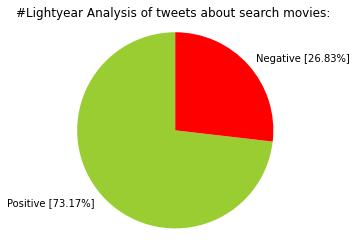

In [51]:
labels = ['Positive ['+str(positive_p)+'%]', 'Negative ['+str(negative_p)+'%]']
sizes = [positive_p, negative_p]
colors = ['yellowgreen','red']
fig, ax = plt.subplots()
ax.pie(sizes,labels=labels,startangle=90,colors=colors)
plt.title(key + " " + "Analysis of tweets about search movies: ")
ax.axis('equal')

plt.show()